In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

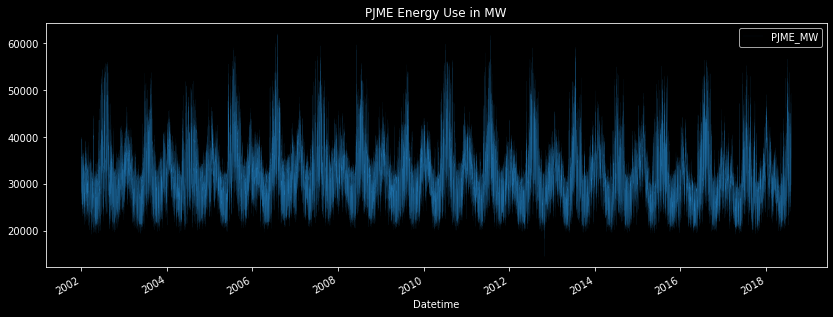

In [4]:
plt.style.use('dark_background')

df.plot(style='-',
        figsize=(14, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW',linewidth=0.05,legend=True)
plt.show()

<AxesSubplot:xlabel='Datetime'>

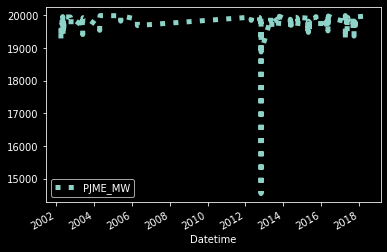

In [5]:
df.query('PJME_MW<20000').plot(ls=':',linewidth=5)

In [6]:
df=df.query('PJME_MW>19000').copy()

In [7]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

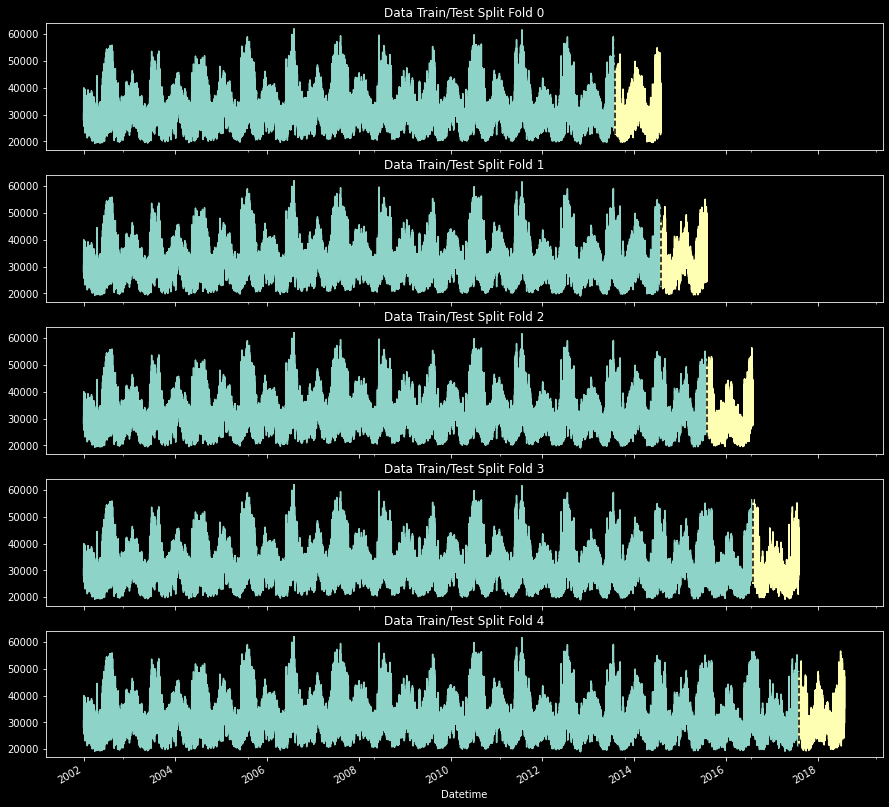

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [9]:
def new_features(df):  
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df=new_features(df)

In [10]:
target_map=df['PJME_MW'].to_dict()

In [11]:
def lag_features(df):
    df['lag1']=(df.index-pd.Timedelta('364 days')).map(target_map)
    df['lag2']=(df.index-pd.Timedelta('728 days')).map(target_map)
    df['lag3']=(df.index-pd.Timedelta('1092 days')).map(target_map)
    return df
df=lag_features(df)

In [12]:
df.isna().sum()

PJME_MW           0
hour              0
dayofweek         0
quarter           0
month             0
year              0
dayofyear         0
dayofmonth        0
weekofyear        0
lag1           8758
lag2          17500
lag3          26240
dtype: int64

In [13]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = new_features(train)
    test = new_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

#  Simplier

In [14]:
model=xgb.XGBRFRegressor()

In [15]:
model.fit(X_train,y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='', max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_state=0,
               reg_alpha=0, sampling_method='uniform', scale_pos_weight=1, ...)

In [16]:
prediction=model.predict(X_test)

In [17]:
test['Prediction']=prediction

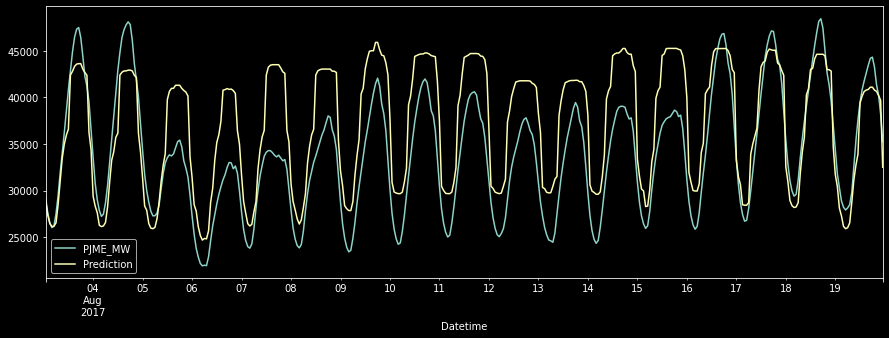

In [21]:
test.query('index<"2017-08-20"').plot(kind='line',figsize=(15,5),y=['PJME_MW','Prediction'])
plt.show()

In [19]:
mean_squared_error(prediction,y_test,squared=False)

3881.2077326640383